In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
# import missingno as msno

import pandas as pd
import numpy as np
import sklearn
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split, StratifiedKFold
sklearn.set_config(transform_output='pandas')
from sklearn.metrics import mean_squared_error, mean_absolute_error

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.preprocessing import LabelEncoder
import mlflow
import mlflow.sklearn
from mlflow import MlflowClient


from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from functools import partial
import optuna
from sklearn.compose import ColumnTransformer
import joblib


from catboost import CatBoostClassifier, Pool


import warnings; warnings.filterwarnings('ignore')



This dataser is taken from Kaggle platform (https://www.kaggle.com/datasets/bhadaneeraj/cardio-vascular-disease-detection)

Features:
1.	Age | Objective Feature | age | int (days)
2.	Height | Objective Feature | height | int (cm) |
3.	Weight | Objective Feature | weight | float (kg) |
4.	Gender | Objective Feature | gender | categorical code |
5.	Systolic blood pressure | Examination Feature | ap_hi | int |
6.	Diastolic blood pressure | Examination Feature | ap_lo | int |
7.	Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
8.	Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
9.	Smoking | Subjective Feature | smoke | binary |
10.	Alcohol intake | Subjective Feature | alco | binary |
11.	Physical activity | Subjective Feature | active | binary |
12.	Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

All of the dataset values were collected at the moment of medical examination.

The Problem Statement:
To build an application to classify the patients to be healthy or suffering from cardiovascular disease based on the given attributes.


# 1 Data

In [16]:
# data = pd.read_csv('data/Covid_data.csv')
data = pd.read_csv('data/cardio_train.csv', sep=';')

data

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,988,22469,1,155,69.0,130,80,2,2,0,0,1,0
1,989,14648,1,163,71.0,110,70,1,1,0,0,1,1
2,990,21901,1,165,70.0,120,80,1,1,0,0,1,0
3,991,14549,2,165,85.0,120,80,1,1,1,1,1,0
4,992,23393,1,155,62.0,120,80,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69296,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
69297,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
69298,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1
69299,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1


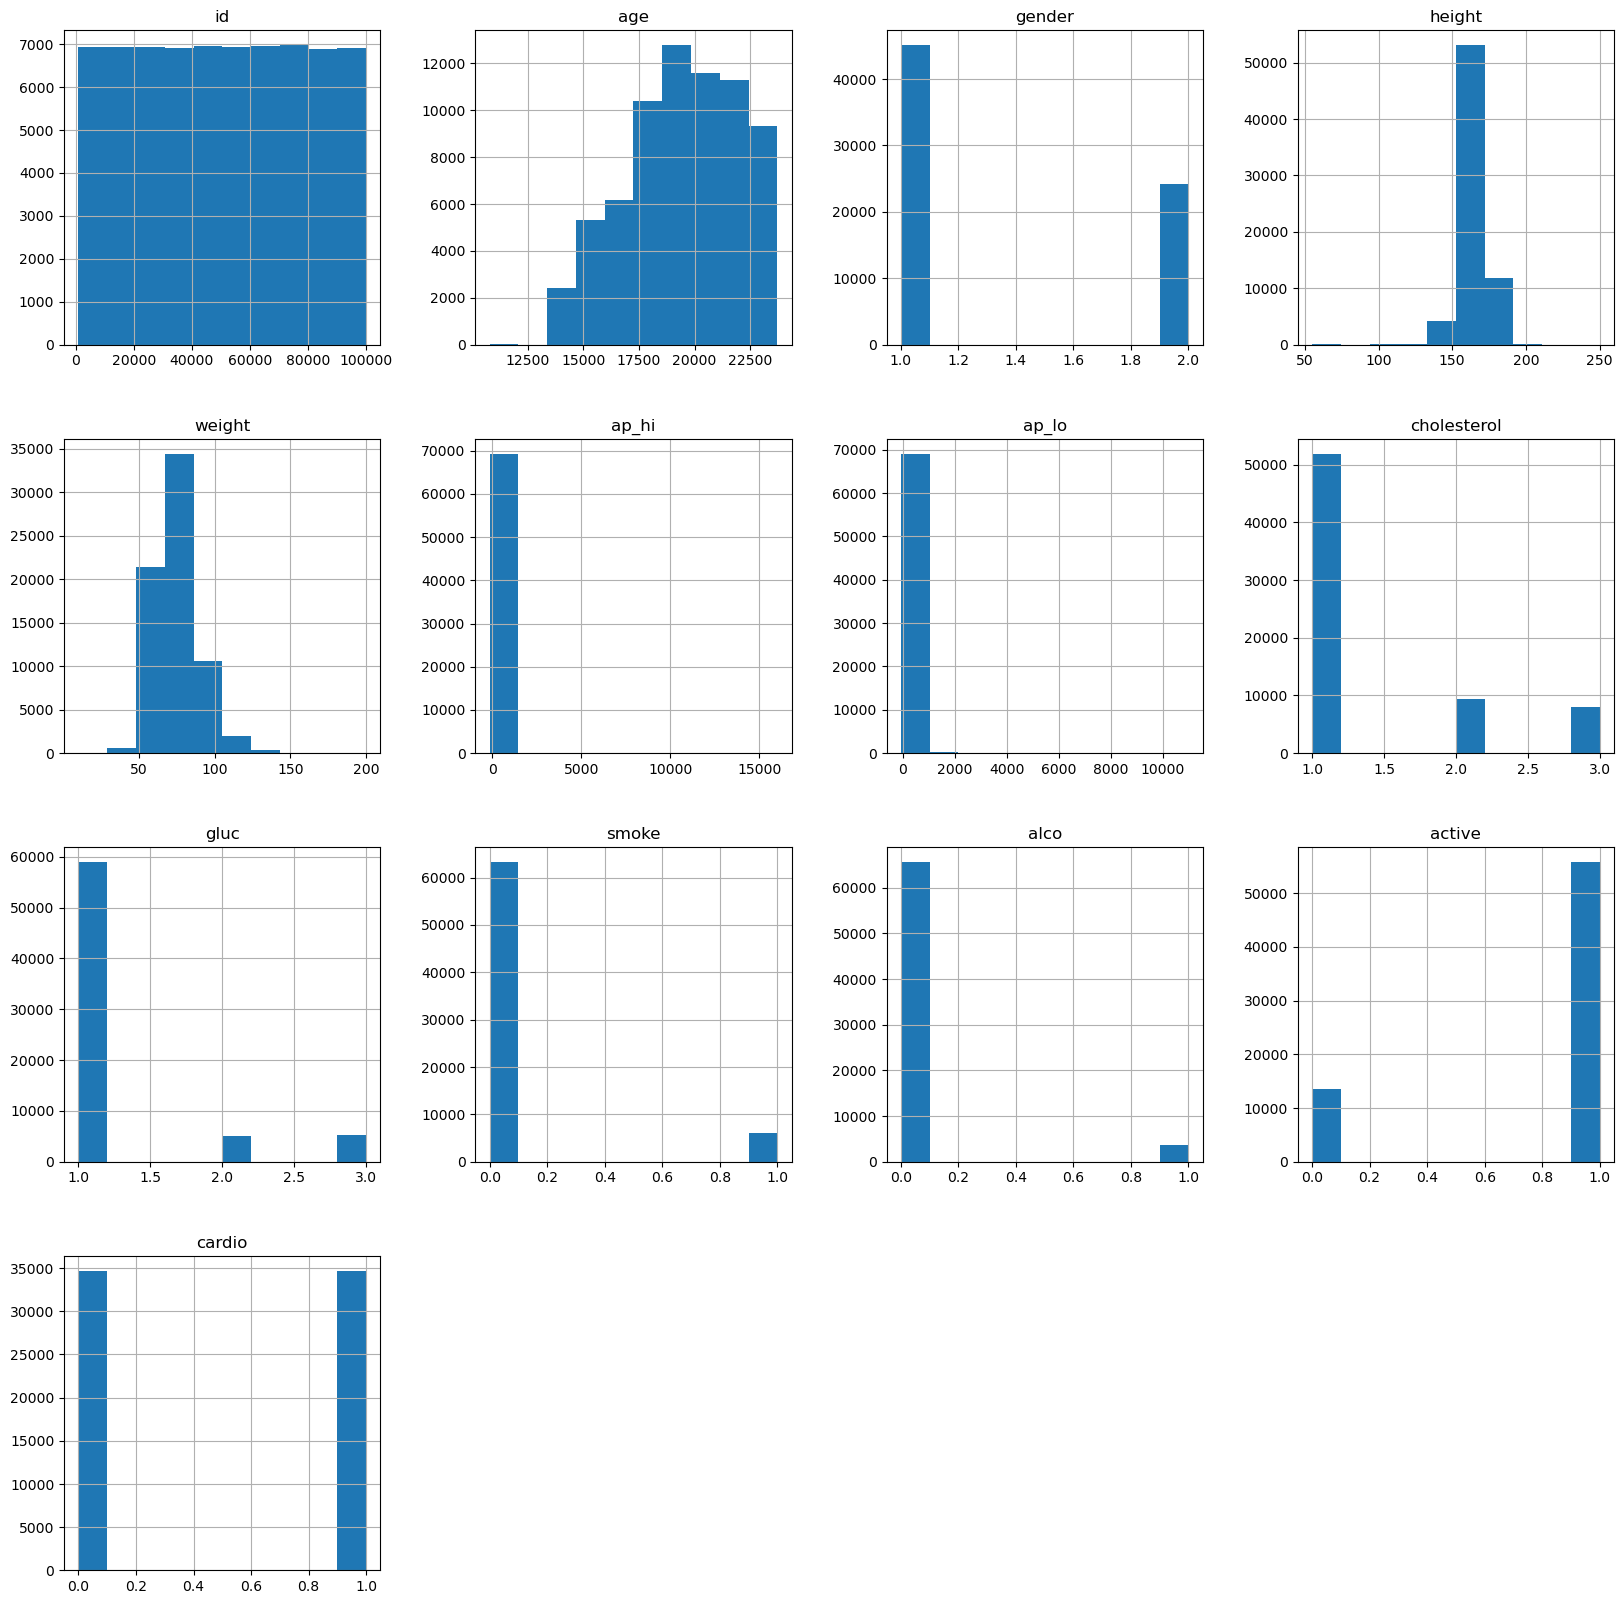

In [17]:
data.hist(figsize=(20, 20));

# 2 Pipeline

In [18]:
X = data.drop('cardio',axis=1)
y = data['cardio']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y,train_size=0.7, random_state=13)


In [20]:
X.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active'],
      dtype='object')

In [21]:
numerical_features = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']

categorical_features = [i for i in X_train.columns if i not in numerical_features]

# numeric data pipeline
pipe_num = Pipeline([
    # ('imputer', SimpleImputer(strategy='median')), # not necessary because we have already clean data 
    ('power_tr', PowerTransformer()),
    ('scaler', StandardScaler()) ])

# cat data pipeline
pipe_cat = Pipeline([
    # ('imputer', SimpleImputer(strategy='constant',fill_value='unknown')), # not necessary because we have already clean data 
    ('encoding', OneHotEncoder(sparse_output=False, handle_unknown='ignore')) ])

# column transformer
ct = ColumnTransformer([
    ('pipe_num', pipe_num, numerical_features),
    ('pipe_cat', pipe_cat, categorical_features) ])

#full pipeline with XGBoost
pipe = Pipeline([
    ('column_transformer', ct),
    ('model', xgb.XGBClassifier()),   
])

In [28]:
mlflow.set_tracking_uri(uri='http://127.0.0.1:5000')
client = MlflowClient()
local_dir = ('C:/Users/Peter/DataspellProjects/kaggle/cardiovascular_disease')

In [ ]:
# optimize hyperparameters with Optuna
def objective(trial):

    # params for optimization
    params = {
        'model__eta': trial.suggest_float('model__eta', 0.01, 0.2),
        'model__gamma': trial.suggest_float('model__gamma', 0.01, 5),
        'model__max_depth': trial.suggest_int('model__max_depth', 3, 10),
        'model__min_child_weight': trial.suggest_float('model__min_child_weight', 1, 10),
        'model__max_delta_step': trial.suggest_float('model__max_delta_step', 0.001, 10),
        'model__subsample': trial.suggest_float('model__subsample', 0.1, 1),
        'model__colsample_bytree': trial.suggest_float('model__colsample_bytree', 0.5, 1),
        'model__colsample_bylevel': trial.suggest_float('model__colsample_bylevel', 0.5, 1),
        'model__colsample_bynode': trial.suggest_float('model__colsample_bynode', 0.5, 1),
        'model__reg_lambda': trial.suggest_float('model__reg_lambda', 1e-5, 1e2),
        'model__reg_alpha': trial.suggest_float('model__reg_alpha', 1e-5, 1e2),
        'model__scale_pos_weight': trial.suggest_float('model__scale_pos_weight', 1, 10),
        'model__max_leaves': trial.suggest_int('model__max_leaves', 1, 100),
    }

    pipe.set_params(**params)

    # model fitting
    cross_val_f1 = cross_val_score(pipe, X_train, list(y_train), scoring='f1').mean()

    return cross_val_f1  # Use F1 score for binary classification


mlflow.set_experiment("MLflow_hype_optuna_XGB")

with mlflow.start_run(run_name='xgb_optuna_run'):
    study = optuna.create_study(direction='maximize')  # Maximize F1 score
    study.optimize(objective, n_trials=3)

    best_trial = study.best_trial
    best_params = best_trial.params

    # Log parameters
    mlflow.log_params(best_params)

    # Set the best parameters to your model
    pipe.set_params(**best_params)

    # Train the model with the best parameters on the entire training set
    pipe.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = pipe.predict(X_test)


    # Metrics
    accuracy = accuracy_score(list(y_test), y_pred)
    recall = recall_score(list(y_test), y_pred)
    f1 = f1_score(list(y_test), y_pred)

    mlflow.sklearn.log_model(pipe, 'xgb_model_optuna')

    # Log metrics
    mlflow.log_metrics({
        'accuracy': accuracy,
        'recall': recall,
        'f1_score': f1,
    })

    # Calculate ROC AUC (if needed for binary classification)
    fpr, tpr, thresholds = roc_curve(list(y_test), y_pred)
    roc_auc = roc_auc_score(list(y_test), y_pred)

    # Plot ROC curve (if needed for binary classification)
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')

    # Save the plot to a local file
    roc_auc_plot_path = "mlruns/roc_auc_plot.png"
    plt.savefig(roc_auc_plot_path)
    plt.close()

    # Log ROC AUC plot as an artifact (if needed for binary classification)
    mlflow.log_artifact(roc_auc_plot_path, "roc_auc_plot")


2024/01/29 00:16:25 INFO mlflow.tracking.fluent: Experiment with name 'MLflow_hype_optuna_XGB' does not exist. Creating a new experiment.
[I 2024-01-29 00:16:25,820] A new study created in memory with name: no-name-f4c1f269-de98-4b7c-9567-b1ab9619fd00
[I 2024-01-29 01:05:52,114] Trial 0 finished with value: 0.7331514985462789 and parameters: {'model__eta': 0.17952609508762965, 'model__gamma': 3.493837574354693, 'model__max_depth': 3, 'model__min_child_weight': 4.473403931581174, 'model__max_delta_step': 8.977632069812799, 'model__subsample': 0.5273787070872685, 'model__colsample_bytree': 0.5910089106369433, 'model__colsample_bylevel': 0.8061550661965885, 'model__colsample_bynode': 0.978986436121156, 'model__reg_lambda': 66.55580091324103, 'model__reg_alpha': 80.09131046612066, 'model__scale_pos_weight': 2.4722768028131505, 'model__max_leaves': 63}. Best is trial 0 with value: 0.7331514985462789.
